# Построение решения с круговой границей

In [1]:
# для того, чтобы скрипты гладко работали на https://colab.research.google.com/ пропишем
# установку библиотеки anaflow которую будем использовать для обратного преобразования Лапласа
!pip install anaflow

In [31]:
!pip install welltest

In [1]:
# импортируем библиотки, которые могут пригодиться для проведения расчетов
import numpy as np
import matplotlib.pyplot as plt
from anaflow import get_lap_inv
from scipy.special import kn, iv, expi

import welltest.functions as wf

надо построить следующие решения

решение для забойного давления при замкнутой границе

$$ \tilde{p}_D(u) = \dfrac{ \dfrac{K_0(\sqrt{u})}{u\sqrt{u}K_1(\sqrt{u})} } {1-\dfrac{K_1({r_{eD}\sqrt{u}})}{I_1({r_{eD}\sqrt{u}})} \dfrac{I_1({\sqrt{u}})}{K_1({\sqrt{u}})}} - 
                    \dfrac{ \dfrac{I_0(\sqrt{u})}{u\sqrt{u}I_1(\sqrt{u})} } {1-\dfrac{I_1({r_{eD}\sqrt{u}})}{K_1({r_{eD}\sqrt{u}})} \dfrac{K_1({\sqrt{u}})}{I_1({\sqrt{u}})}} $$
                    
                    
решение для забойного давления при границе постоянного давления

$$ \tilde{p}_D(u) = \dfrac{ \dfrac{K_0(\sqrt{u})}{u\sqrt{u}K_1(\sqrt{u})} } {1+\dfrac{K_1({r_{eD}\sqrt{u}})}{I_1({r_{eD}\sqrt{u}})} \dfrac{I_1({\sqrt{u}})}{K_1({\sqrt{u}})}} - 
                    \dfrac{ \dfrac{I_0(\sqrt{u})}{u\sqrt{u}I_1(\sqrt{u})} } {1+\dfrac{I_1({r_{eD}\sqrt{u}})}{K_1({r_{eD}\sqrt{u}})} \dfrac{K_1({\sqrt{u}})}{I_1({\sqrt{u}})}} $$

In [11]:
# функция расчета безразмерного давления с использованием алгоритма Стефеста
# для численного обратного преобразования Лапласа
def pd_circle_closed(u, rd=1, r_ed=1000):
    """
    расчет решения в пространстве Лапласа для замкнутой круговой границы
    u -  переменная пространства Лапласа
    r_ed - безразмерный радиус контура
    """
    sqrtu = u ** 0.5
    r_ed_sqrtu = r_ed * sqrtu
    
    pd = (( kn(0, sqrtu) / (u*sqrtu*kn(1,sqrtu)) ) /
         (1 - kn(1, r_ed_sqrtu) / iv(1, r_ed_sqrtu) * iv(1, sqrtu)/kn(1, sqrtu) ) - 
         ( iv(0, sqrtu) / (u*sqrtu*iv(1,sqrtu)) ) /
         (1 - iv(1, r_ed_sqrtu) / kn(1, r_ed_sqrtu) * kn(1, sqrtu)/iv(1, sqrtu) ))
    return pd


def pd_circle_closed_(u, rd=1, r_ed=1000):
    """
    как в excel
    """
    
    uK1 = u ** 0.5 * kn(1, u ** 0.5)
    uI1 = u ** 0.5 * iv(1, u ** 0.5)
    
    # to avoid division by zero set limit values of normalizing coefficients
    #if u ** 0.5 * r_ed > 700:
    #    K1r = 0
    #    I1r = 1
    #else:
    K1r = kn(1, u ** 0.5 * r_ed)
    I1r = iv(1, u ** 0.5 * r_ed)
       
    #if u ** 0.5 * r_ed > 700:
    #    K0r = 0
    #    I0r = 1
    #else:
    K0r = kn(0, u ** 0.5 * r_ed)
    I0r = iv(0, u ** 0.5 * r_ed)

    K0 = kn(0, u ** 0.5)
    I0 = iv(0, u ** 0.5)

    return  (I1r * K0 + K1r * I0) / (u * (I1r * uK1 - K1r * uI1))
    """
    Select Case BoundaryType
    Case 1 'no flow
     Pd = (I1r * K0 + K1r * I0) / (Z * (I1r * zK1 - K1r * zI1))
    Case 2 'constant pressure
     Pd = (I0r * K0 - K0r * I0) / (Z * (I0r * zK1 + K0r * zI1))
    End Select
    """


def pd_circle_const_pressure_(u, rd=1, r_ed=1000):
    """
    как в excel
    """
    
    uK1 = u ** 0.5 * kn(1, u ** 0.5)
    uI1 = u ** 0.5 * iv(1, u ** 0.5)
    
    # to avoid division by zero set limit values of normalizing coefficients
    #if u ** 0.5 * r_ed > 700:
    #    K1r = 0
    #    I1r = 1
    #else:

    K1r = kn(1, u ** 0.5 * r_ed)
    I1r = iv(1, u ** 0.5 * r_ed)
       
    #if u ** 0.5 * r_ed > 700:
    #    K0r = 0
    #    I0r = 1
    #else:
    K0r = kn(0, u ** 0.5 * r_ed)
    I0r = iv(0, u ** 0.5 * r_ed)

    K0 = kn(0, u ** 0.5)
    I0 = iv(0, u ** 0.5)

    return  (I0r * K0 - K0r * I0) / (u * (I0r * uK1 + K0r * uI1))
    """
    Select Case BoundaryType
    Case 1 'no flow
     Pd = (I1r * K0 + K1r * I0) / (Z * (I1r * zK1 - K1r * zI1))
    Case 2 'constant pressure
     Pd = (I0r * K0 - K0r * I0) / (Z * (I0r * zK1 + K0r * zI1))
    End Select
    """

# функция расчета безразмерного давления с использованием алгоритма Стефеста
# для численного обратного преобразования Лапласа
def pd_circle_const_pressure(u, rd=1, r_ed=1000):
    """
    расчет решения в пространстве Лапласа для круговой границы c постоянным давлением
    u -  переменная пространства Лапласа
    r_ed - безразмерный радиус контура
    """
    sqrtu = u ** 0.5
    r_ed_sqrtu = r_ed * sqrtu
    
    pd = (( kn(0, sqrtu) / (u*sqrtu*kn(1,sqrtu)) ) /
         (1 + kn(1, r_ed_sqrtu) / iv(1, r_ed_sqrtu) * iv(1, sqrtu)/kn(1, sqrtu) ) - 
         ( iv(0, sqrtu) / (u*sqrtu*iv(1,sqrtu)) ) /
         (1 + iv(1, r_ed_sqrtu) / kn(1, r_ed_sqrtu) * kn(1, sqrtu)/iv(1, sqrtu) ))
    return pd


# пример функции реализующий расчет решения в пространстве Лапласа
def pd_lapl_finite_rw(u, rd=1):
    """
    расчет решения c конечным радиусом скважины для безразмерного давления в пространстве Лапласа
    u - переменная пространства Лапласа
    rd- безразмерное расстояние от центра скважины
    """
    return 1 / u**(3/2) * kn(0, rd * u**0.5) / kn(1, u**0.5)

In [54]:
# решение линейного стока в пространстве Лапласа
def pd_lapl_wbs(pd_lapl, S=0, Cd=0):
    def pdl(u, rd=1, S=S, Cd=Cd):
        return 1 / u * (S + u * pd_lapl(u, rd=rd)) / (1 + u * Cd * (S + u * pd_lapl(u, rd=rd)))
    return pdl

In [55]:
# построим функцию инвертирующую решение в пространстве Лапласа

# функция расчета безразмерного давления с использованием алгоритма Стефеста
# для численного обратного преобразования Лапласа
def pd_inv(pd_lapl, td, rd, **kwargs):
     
    
    if isinstance(rd, np.ndarray):
        # если на входе массив, то вручную итерируем по всем элементам и 
        # собираем массив массивов
        return np.array(list(map(lambda r: pd_inv(pd_lapl, td, rd=r, **kwargs), rd)))
    else:
        pd_inv_ = get_lap_inv(pd_lapl, rd=rd, **kwargs)
        return pd_inv_(td)

In [56]:
pd_inv(pd_lapl_wbs(pd_circle_closed, 0),0.001,1)

array([0.03519121])

In [14]:
pd_circle_closed(1)

0.6994839355937723

In [23]:
pd_circle_cl = pd_lapl_wbs(pd_circle_closed, S=5, Cd = 1e-3)
pd_circle_cl_ = pd_lapl_wbs(pd_circle_closed_, S=50, Cd = 1e-3)
pd_circle_const_pressure = pd_lapl_wbs(pd_circle_const_pressure, S=5, Cd = 1e-3)
pd_circle_const_pressure_ = pd_lapl_wbs(pd_circle_const_pressure_, S=5, Cd = 1e-3)
pd_inf = pd_lapl_wbs(pd_lapl_finite_rw, S=5, Cd = 1e-3)

In [24]:
td_arr = np.linspace(1, 1e6, 1000)

In [37]:
pd_arr_circe_cl = pd_inv(pd_circle_cl, td=td_arr, rd=1, S=0, Cd=0)
pd_arr_circe_cl_ = pd_inv(pd_circle_cl_, td=td_arr, rd=1, S=1, Cd=0)
pd_arr_circe_const_pressure = pd_inv(pd_circle_const_pressure, td=td_arr, rd=1, S=0, Cd=0)
pd_arr_circe_const_pressure_ = pd_inv(pd_circle_const_pressure_, td=td_arr, rd=1, S=0, Cd=0)
pd_arr_inf = pd_inv(pd_inf, td=td_arr, rd=1, S=0, Cd=0)

/tmp/ipykernel_7161/2642990535.py:45: RuntimeWarning: invalid value encountered in divide
  return  (I1r * K0 + K1r * I0) / (u * (I1r * uK1 - K1r * uI1))
/tmp/ipykernel_7161/2642990535.py:83: RuntimeWarning: invalid value encountered in divide
  return  (I0r * K0 - K0r * I0) / (u * (I0r * uK1 + K0r * uI1))


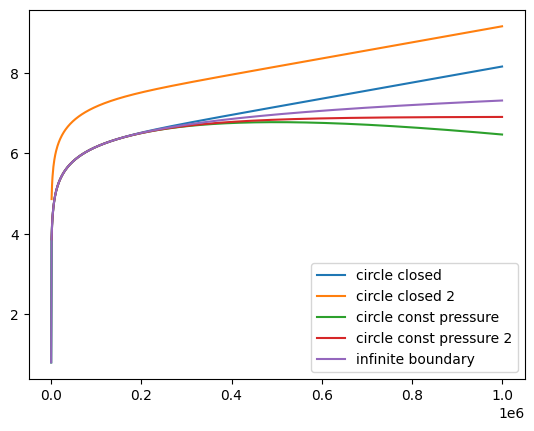

In [38]:
plt.plot(td_arr, pd_arr_circe_cl, label ='circle closed')
plt.plot(td_arr, pd_arr_circe_cl_, label ='circle closed 2')
plt.plot(td_arr, pd_arr_circe_const_pressure, label ='circle const pressure')
plt.plot(td_arr, pd_arr_circe_const_pressure_, label ='circle const pressure 2')
plt.plot(td_arr, pd_arr_inf, label = 'infinite boundary')
plt.legend()
plt.show()

In [114]:
k=10
q=50
t_arr = wf.t_from_td_hr(td_arr, k_mD=k, ct_1atm=1e-4)
p_arr_circle_cl = wf.p_from_pd_atma(pd_arr_circe_cl, k_mD=k, q_sm3day=q)
p_arr_circle_cl_ = wf.p_from_pd_atma(pd_arr_circe_cl_, k_mD=k, q_sm3day=q)
p_arr_circle_const_pressure = wf.p_from_pd_atma(pd_arr_circe_const_pressure, k_mD=k, q_sm3day=q)
p_arr_circle_const_pressure_ = wf.p_from_pd_atma(pd_arr_circe_const_pressure_, k_mD=k, q_sm3day=q)
p_arr_inf = wf.p_from_pd_atma(pd_arr_inf, k_mD=k, q_sm3day=q)

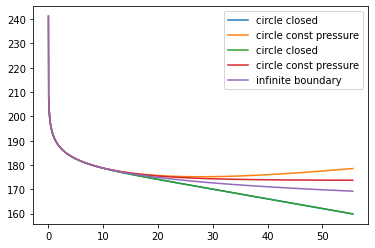

In [115]:
plt.plot(t_arr, p_arr_circle_cl, label ='circle closed')
plt.plot(t_arr, p_arr_circle_const_pressure, label ='circle const pressure')
plt.plot(t_arr, p_arr_circle_cl_, label ='circle closed')
plt.plot(t_arr, p_arr_circle_const_pressure_, label ='circle const pressure')
plt.plot(t_arr, p_arr_inf, label = 'infinite boundary')
plt.legend()
plt.show()

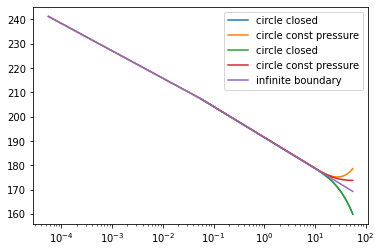

In [116]:
plt.plot(t_arr, p_arr_circle_cl, label ='circle closed')
plt.plot(t_arr, p_arr_circle_const_pressure, label ='circle const pressure')
plt.plot(t_arr, p_arr_circle_cl_, label ='circle closed')
plt.plot(t_arr, p_arr_circle_const_pressure_, label ='circle const pressure')
plt.plot(t_arr, p_arr_inf, label = 'infinite boundary')
plt.xscale('log')
plt.legend()
plt.show()